# Final Project - CNN model
In this notebook we preprocess the car data and build a CNN classifier.

## Packages And Functions

In [25]:
# Packages
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.layers import (Conv2D, 
                          Dense, 
                          Flatten, 
                          MaxPooling2D, 
                          Input, 
                          Dropout, 
                          GlobalAveragePooling2D, 
                          BatchNormalization)
from keras.models import Sequential, Model

# Document variables
RANDOM_STATE = 42
IMAGE_SIZE = (128, 128)

In [2]:
def resize_image(image_path, target_size):
    """
    This function allows to resize given images to a predefined size.
    Inputs: 
        image_path: path to the image that needs to be resized
        target_size: tuple of len 2, containing the dimensions for the resized image
    """
    image = Image.open(image_path)
    resized_image = image.resize(target_size)
    
    return resized_image

def load_images(folder, target_size):
    """
    This function loads in images from a folder with their corresponding label. The images are resized automatically.
    Input:
        folder: Folder from which the images are extracted
    """
    image_data = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder) and label != 'unknown':
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = np.array(resize_image(img_path, target_size))
                image_data.append({'image': img, 'label': label})
    return pd.DataFrame(image_data)

## Load in the data

First we load in the data, containing images of cars from different sides. These are loaded in with their label into a dataframe

In [3]:
data = load_images("../data", IMAGE_SIZE)

                                               image                    label
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  3_4th_driver_side_front
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  3_4th_driver_side_front
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  3_4th_driver_side_front
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  3_4th_driver_side_front
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  3_4th_driver_side_front


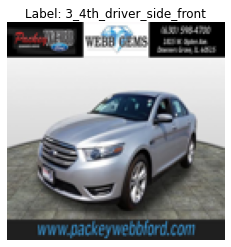

In [4]:
# Print first instances
print(data.head())

# plot first image
plt.imshow(data['image'][0])
plt.title('Label: ' + data['label'][0])
plt.axis('off')
plt.show()

In [5]:
# Check if the data is balanced
label_counts = data['label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Frequency']

print(label_counts)

                        Label  Frequency
0                 driver_side        500
1                        rear        500
2              passenger_side        500
3                       front        500
4  3_4th_passenger_side_front        500
5     3_4th_driver_side_front        500
6      3_4th_driver_side_rear        500
7   3_4th_passenger_side_rear        500


## Split the data
The data is normalized, one-hot encoded and split in train, validation and test data.

In [34]:
# Normalization
X = data['image']
X_normalized = []
for img in X:
    img_normalized = img / 255.0
    X_normalized.append(img_normalized)
X = np.array(X_normalized)

# One-hot encoding
y = data['label']
y = OneHotEncoder(sparse_output=False, dtype=int).fit_transform(y.values.reshape(-1, 1))

# Data splitting
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state = RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state = RANDOM_STATE)

# Convert image data to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Size data sets
print('Train set:', len(X_train))
print('Validation set:', len(X_val))
print('Test set:', len(X_test))

Train set: 2400
Validation set: 800
Test set: 800


## CNN model
We will be constructing a CNN model to classify the images.
Architecture was derived from <a href="(https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification">learndatasci.com</a>

In [22]:
IMAGE_SIZE = IMAGE_SIZE + (3,)
# The model

def CNN(input_shape=IMAGE_SIZE, num_classes=8):
    model = Sequential()
    model.add(Input(input_shape))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                     activation='relu'))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
    model.add(Conv2D(512, (5,5), activation='relu'))
    model.add(MaxPooling2D((4,4)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [35]:
# training the model
model = CNN()
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
38/38 [==============================] - 245s 6s/step - loss: 2.0814 - accuracy: 0.1142 - val_loss: 2.0794 - val_accuracy: 0.1250
Epoch 2/10
38/38 [==============================] - 228s 6s/step - loss: 2.0797 - accuracy: 0.1250 - val_loss: 2.0793 - val_accuracy: 0.1250
Epoch 3/10
38/38 [==============================] - 230s 6s/step - loss: 2.0796 - accuracy: 0.1300 - val_loss: 2.0797 - val_accuracy: 0.1250
Epoch 4/10
38/38 [==============================] - 227s 6s/step - loss: 2.0794 - accuracy: 0.1158 - val_loss: 2.0797 - val_accuracy: 0.1250
Epoch 5/10
38/38 [==============================] - 227s 6s/step - loss: 2.0794 - accuracy: 0.1117 - val_loss: 2.0799 - val_accuracy: 0.1238
Epoch 6/10
38/38 [==============================] - 226s 6s/step - loss: 2.0793 - accuracy: 0.1196 - val_loss: 2.0797 - val_accuracy: 0.1250
Epoch 7/10
38/38 [==============================] - 228s 6s/step - loss: 2.0792 - accuracy: 0.1267 - val_loss: 2.0797 - val_accuracy: 0.1238
Epoch 8/10
38

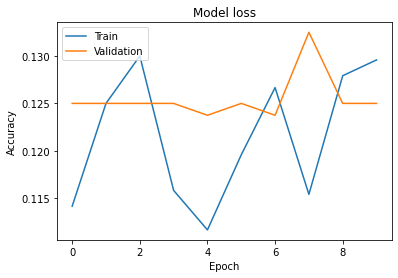

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()